In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
from scipy.stats import hypergeom
from matplotlib import colors as mcolors
from scgenome import cncluster
from scdna_replication_tools.plot_utils import get_rt_cmap, get_phase_cmap, get_clone_cmap, plot_colorbar, make_color_mat_float, plot_clustered_cell_cn_matrix

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 3
despine_trim = True

### Load and preprocess data for cell cycle clone counts for SA039 

In [3]:
def timepoint_to_int(df):
    """Converts the timepoint column to an integer"""
    # get the timepoint column
    timepoints = df['timepoint'].values
    # convert the timepoints to integers
    timepoints = [int(x[1:]) for x in timepoints]
    # add the timepoints to the dataframe
    df['timepoint_int'] = timepoints
    # return the dataframe
    return df


def sort_timepoints(df):
    """Sort the dataframe according to clone_id and timepoint_int"""
    # if timepoint_int is not in the dataframe, create such a column
    df = timepoint_to_int(df)
    # sort the dataframe
    df = df.sort_values(by=['clone_id', 'timepoint_int'])
    # return the dataframe
    return df


def fill_in_missing_clones(df, clone_list=None):
    """ If there are clones present at some timepoints but not others, fill in the missing clones with 0s """
    # find the clone list if not specified
    if clone_list is None:
        clone_list = df.clone_id.unique()
    # loop through the clones and timepoints
    for clone in clone_list:
        for timepoint in df.timepoint.unique():
            # if the clone is not present at the timepoint, add a row with 0s
            if clone not in df[df.timepoint == timepoint].clone_id.values:
                new_line = pd.DataFrame({
                    'clone_id': [clone], 'timepoint': [timepoint], 'num_cells_s': [0], 'num_cells_g': [0],
                    'clone_frac_s': [0], 'clone_frac_g': [0], 'positive_p': [0], 'negative_p': [0],
                    'positive_p_adj': [0], 'negative_p_adj': [0], 'timepoint_int': [int(timepoint[1:])]
                })
                # concatenate the new line to the dataframe
                df = pd.concat([df, new_line], ignore_index=True)
    return df


def compute_clone_fracs_vs_time(df):
    """
    Computes the fraction of cells in each clone for each timepoint.
    """
    clone_frac_g_vs_time = np.zeros((len(df.clone_id.unique()), len(df.timepoint_int.unique())))
    clone_frac_s_vs_time = np.zeros((len(df.clone_id.unique()), len(df.timepoint_int.unique())))
    clone_legend = []
    timepoints = df.timepoint_int.unique()
    i = 0
    for clone_id, chunk in df.groupby('clone_id'):
        chunk.sort_values(by='timepoint_int', inplace=True)
        clone_frac_g_vs_time[i] = chunk['clone_frac_g'].values
        clone_frac_s_vs_time[i] = chunk['clone_frac_s'].values
        clone_legend.append(clone_id)
        i += 1
    return timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend

In [4]:
# load the cell cycle clone counts for SA039
df_SA039 = pd.read_csv('../../analysis/fitness_lines_old/SA039/cell_cycle_clone_counts.tsv', sep='\t')

# sort timepoints based on the timepoint_int column
df_SA039 = sort_timepoints(df_SA039)

# find the earliest timepoint in the untreated sample
earliest_timepoint = sorted(df_SA039.timepoint_int.unique())[0]

# find the set of clone_ids that appear in the union of the treated and untreated samples
clone_list = list(set(df_SA039.clone_id.unique()))
# fill in missing clones with 0s
df_SA039 = fill_in_missing_clones(df_SA039, clone_list)

# sort timepoints again now that we've added the earliest untreated timepoint and filled in missing clones
df_SA039 = sort_timepoints(df_SA039)

### Plot the fraction of cells in each cell cycle phase for each clone across all timepoints

In [5]:
def plot_clone_stackplots(df_U, dataset, ax_g, ax_s):
    """
    Plots the evolution of clones over time for each cell cycle phase. 
    """
    # split the dataframe based on cell cycle and find the fraction of cells in each clone at each timepoint for each cell cycle phase
    timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend = compute_clone_fracs_vs_time(df_U)
    # plot as a stackplot
    baseline = 'zero'
    ax_g.stackplot(timepoints, clone_frac_g_vs_time, labels=clone_legend, baseline=baseline)
    ax_s.stackplot(timepoints, clone_frac_s_vs_time, labels=clone_legend, baseline=baseline)
    ax_g.set_ylabel('clone fraction')
    ax_g.set_xlabel('timepoint')
    ax_s.set_xlabel('timepoint')
    ax_g.set_title('{}: G1/2-phase'.format(dataset))
    ax_s.set_title('{}: S-phase'.format(dataset))
    ax_s.legend(title='clone')

In [6]:
def plot_clone_muller(df, dataset, ax_g, ax_s, interpolate=True, std=5, clone_cmap=get_clone_cmap()):
    """
    Plots the evolution of clones over time for each cell cycle phase. 
    """
    # split the dataframe based on cell cycle and find the fraction of cells in each clone at each timepoint for each cell cycle phase
    timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend = compute_clone_fracs_vs_time(df)
    og_timepoints = timepoints

    if interpolate:
        clone_frac_g_vs_time = pd.DataFrame(clone_frac_g_vs_time, index=clone_legend, columns=timepoints)
        clone_frac_s_vs_time = pd.DataFrame(clone_frac_s_vs_time, index=clone_legend, columns=timepoints)
            
        # add columns with NaNs for the 0.5 intervals betweeen timepoints
        for i in range(min(timepoints), max(timepoints)):
            for frac in np.linspace(0.1, 0.9, 9):
                clone_frac_g_vs_time[i + frac] = np.nan
                clone_frac_s_vs_time[i + frac] = np.nan

        # sort the columns based on timepoint
        clone_frac_g_vs_time = clone_frac_g_vs_time.reindex(sorted(clone_frac_g_vs_time.columns), axis=1)
        clone_frac_s_vs_time = clone_frac_s_vs_time.reindex(sorted(clone_frac_s_vs_time.columns), axis=1)
        timepoints = clone_frac_g_vs_time.columns

        # interpolate the NaNs
        # clone_frac_g_vs_time = clone_frac_g_vs_time.interpolate(method='spline', order=3, axis=1)
        # clone_frac_s_vs_time = clone_frac_s_vs_time.interpolate(method='spline', order=3, axis=1)
        clone_frac_g_vs_time = clone_frac_g_vs_time.T.rolling(len(timepoints), 1, True, 'gaussian').mean(std=std).T
        clone_frac_s_vs_time = clone_frac_s_vs_time.T.rolling(len(timepoints), 1, True, 'gaussian').mean(std=std).T
    
    # set x-axis ticks to all the timepoints we have measurements for
    ax_g.set_xticks(og_timepoints)
    ax_s.set_xticks(og_timepoints)

    clone_colors = [clone_cmap[x] for x in clone_legend]

    # plot as a stackplot
    baseline = 'zero'
    ax_g.stackplot(timepoints, clone_frac_g_vs_time, labels=clone_legend, baseline=baseline, colors=clone_colors)
    ax_s.stackplot(timepoints, clone_frac_s_vs_time, labels=clone_legend, baseline=baseline, colors=clone_colors)
    ax_g.set_ylabel('clone fraction')
    ax_g.set_xlabel('timepoint')
    ax_s.set_xlabel('timepoint')
    ax_g.set_title('{}: G1/2-phase'.format(dataset))
    ax_s.set_title('{}: S-phase'.format(dataset))
    ax_s.legend(title='clone')
    # set the x-axis limits to be the very first and last timepoints
    ax_s.set_xlim(min(timepoints), max(timepoints))
    ax_g.set_xlim(min(timepoints), max(timepoints))

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


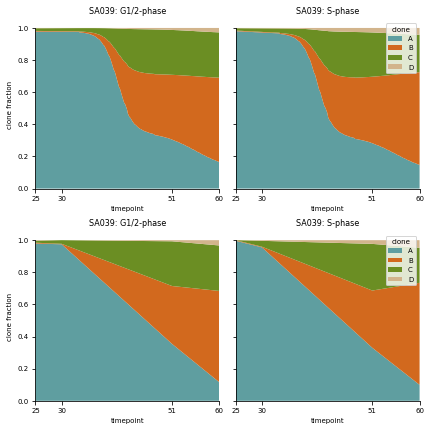

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True, sharey=True)
ax = ax.flatten()

# plot clone fractions for each phase & timepoint in the form of a stackplot
plot_clone_muller(df_SA039, 'SA039', ax[0], ax[1], std=50)
plot_clone_muller(df_SA039, 'SA039', ax[2], ax[3], interpolate=False)
sns.despine(ax=ax[0], offset=0, trim=despine_trim)
sns.despine(ax=ax[1], offset=0, trim=despine_trim)
sns.despine(ax=ax[2], offset=0, trim=despine_trim)
sns.despine(ax=ax[3], offset=0, trim=despine_trim)

plt.show()

### Check to see that the muller plots look reasonable across all datasets

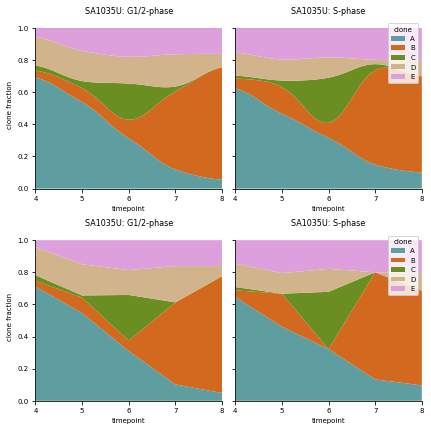

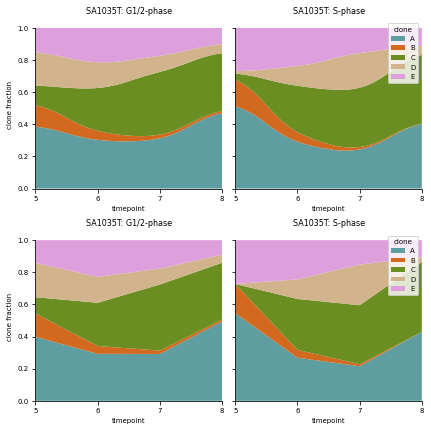

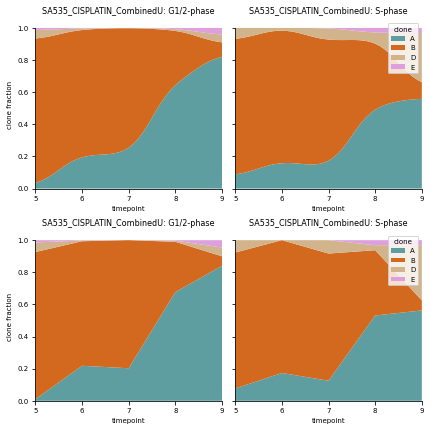

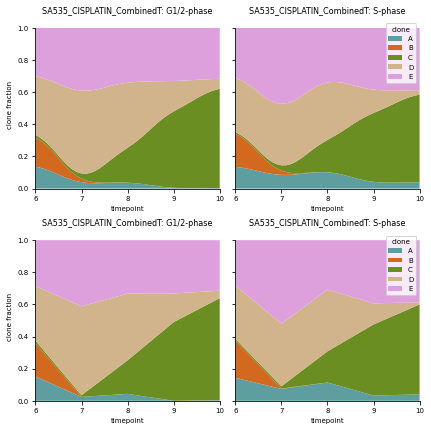

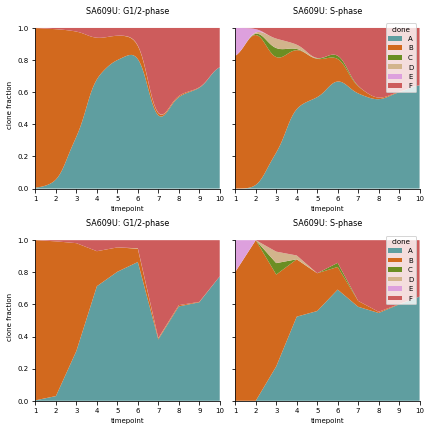

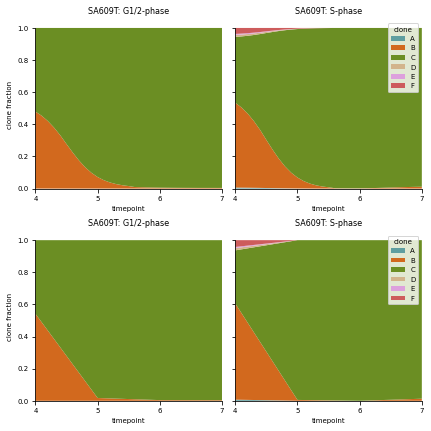

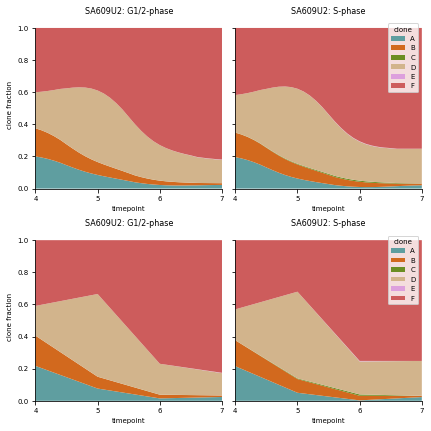

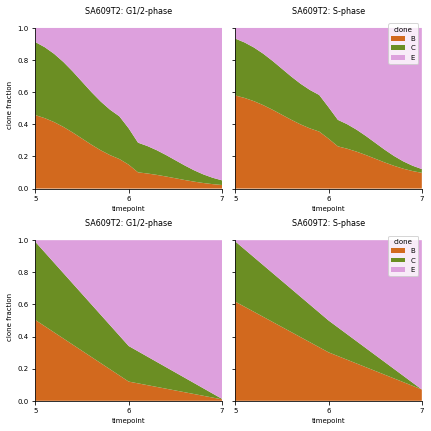

In [8]:
datasets = ['SA1035U', 'SA1035T', 'SA535_CISPLATIN_CombinedU', 'SA535_CISPLATIN_CombinedT', 'SA609U', 'SA609T', 'SA609U2', 'SA609T2']
for d in datasets:
    # load the cell cycle clone counts for SA039
    temp_df = pd.read_csv('../../analysis/fitness/{}/cell_cycle_clone_counts.tsv'.format(d), sep='\t')

    # sort timepoints based on the timepoint_int column
    temp_df = sort_timepoints(temp_df)

    # find the earliest timepoint in the untreated sample
    earliest_timepoint = sorted(temp_df.timepoint_int.unique())[0]

    # find the set of clone_ids that appear in the union of the treated and untreated samples
    clone_list = list(set(temp_df.clone_id.unique()))
    # fill in missing clones with 0s
    temp_df = fill_in_missing_clones(temp_df, clone_list)

    # sort timepoints again now that we've added the earliest untreated timepoint and filled in missing clones
    temp_df = sort_timepoints(temp_df)

    fig, ax = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True, sharey=True)
    ax = ax.flatten()
    # plot clone fractions for each phase & timepoint in the form of a stackplot
    plot_clone_muller(temp_df, d, ax[0], ax[1], std=5)
    plot_clone_muller(temp_df, d, ax[2], ax[3], interpolate=False)
    sns.despine(ax=ax[0], offset=0, trim=despine_trim)
    sns.despine(ax=ax[1], offset=0, trim=despine_trim)
    sns.despine(ax=ax[2], offset=0, trim=despine_trim)
    sns.despine(ax=ax[3], offset=0, trim=despine_trim)
    plt.show()

### Plot the S-phase enrichment of SA039 clones across all timepoints

In [9]:
def plot_s_phase_enrichment(df, dataset, ax0, ax1, pt_size=5):
    # compute the maximum and minimum timepoints
    df['timepoint_ind'] = df['timepoint_int'].astype(int)
    max_time = df['timepoint_int'].max()
    min_time = df['timepoint_int'].min()

    pthresh = 1e-2

    # create custom legend for clones & timepoints
    clone_cmap = get_clone_cmap()
    viridis = cm.get_cmap('viridis', 256)
    timepoint_cmap = {}
    clone_legend_elements = [
        Line2D([0], [0], marker='^', color='w', label='enriched'.format(pthresh), markerfacecolor='k', markersize=pt_size),
        Line2D([0], [0], marker='o', color='w', label='non-sig.'.format(pthresh), markerfacecolor='k', markersize=pt_size),
        Line2D([0], [0], marker='v', color='w', label='depleted'.format(pthresh), markerfacecolor='k', markersize=pt_size)
    ]
    timepoint_legend_elements = clone_legend_elements.copy()
    for i, c in enumerate(sorted(df.clone_id.unique())):
        color = clone_cmap[c]
        # clone_legend_elements.append(Patch(facecolor=color, label=c))

    for i, t in enumerate(sorted(df.timepoint_int.unique())):
        color = viridis((t - min_time) / (max_time - min_time))
        timepoint_str = 'X{}'.format(t)
        timepoint_cmap[timepoint_str] = color
        # timepoint_legend_elements.append(Patch(facecolor=color, label=timepoint_str))

    # draw scatterplot comparing the relative fraction of each clone in S vs G1/2 phases
    for i, row in df.iterrows():
        clone_id = row['clone_id']
        timepoint = row['timepoint']
        if row['positive_p_adj'] < pthresh:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], marker='^', s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=timepoint_cmap[timepoint], marker='^', s=pt_size)
        elif row['negative_p_adj'] < pthresh:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], marker='v', s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=timepoint_cmap[timepoint], marker='v', s=pt_size)
        else:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=timepoint_cmap[timepoint], s=pt_size)

    # draw y=x line where we expect "neutral" clones to lie
    lims = [
        np.min([ax0.get_xlim(), ax0.get_ylim()]),  # min of both axes
        np.max([ax0.get_xlim(), ax0.get_ylim()]),  # max of both axes
    ]
    ax0.plot(lims, lims, 'k--', alpha=0.25, zorder=0)
    ax1.plot(lims, lims, 'k--', alpha=0.25, zorder=0)

    dataset = dataset.replace('_CISPLATIN_Combined', '')

    # ax0.legend(handles=clone_legend_elements, title='clone')
    ax0.legend(handles=clone_legend_elements, title='S-phase', frameon=False, loc='lower right')
    ax0.set_title('{}: S-phase enrichment\ncolored by clone'.format(dataset))
    ax1.set_title('{}: S-phase enrichment\ncolored by timepoint'.format(dataset))
    ax0.set_ylabel('S-phase clone fraction')
    for ax in [ax0, ax1]:
        ax.set_xlabel('G1/2-phase clone fraction')



    

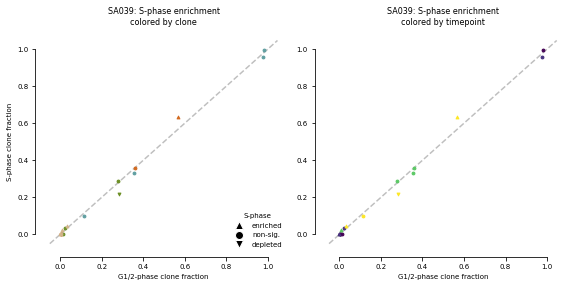

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

# plot S-phase enrichment for SA039
plot_s_phase_enrichment(df_SA039, 'SA039', ax[0], ax[1], pt_size=8)
sns.despine(ax=ax[0], offset=despine_offset, trim=despine_trim)
sns.despine(ax=ax[1], offset=despine_offset, trim=despine_trim)

plt.show()

### Load and process the cell cycle clone counts for all treated or untreated samples in the fitness cohort

In [11]:
def filter_rows(df, num_cells=10):
    """Filters out rows that do not have a value for SPE_scor or have few cells"""
    # convert SPE values with -inf to -12 and inf to 12
    # I am using 12 since this is the max precision of floats which would produce NaN values
    df['SPE_score'] = df['SPE_score'].replace(-np.inf, -12)
    df['SPE_score'] = df['SPE_score'].replace(np.inf, 12)
    df = df.loc[df['SPE_score'].notna()]
    df = df.loc[df['instantaneous_s'].notna()]
    df = df.loc[df['num_cells_g'] > num_cells]
    return df


def add_instantaneous_s_and_enrichment(df):
    """Adds a column to the dataframe that contains the observed clone shift in G1/2 population for each clone at each timepoint"""
    # compute the enrichment or depletion for S-phase cells at a given timepoint
    df['clone_frac_diff'] = df['clone_frac_s'] - df['clone_frac_g']

    times = sorted(df.timepoint_int.unique())
    clones = sorted(df.clone_id.unique())

    # this column is a proxy for that clone's instatneous selection coefficient
    df['instantaneous_s'] = np.nan

    # find difference in a clone's number/fraction of cells between two adjacent timepoints
    for t in range(len(times)-1):
        for c in clones:
            t0 = times[t]
            t1 = times[t+1]
            # find the row that corresponds to this clone & time
            row_t0 = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t0)]
            row_t1 = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t1)]
            # find the difference in G1/2-phase fractions between t0 and t1
            frac_diff = row_t1['clone_frac_g'].values[0] - row_t0['clone_frac_g'].values[0]

            # add frac_diff to the dataframe at the appropriate row
            df.loc[(df['clone_id']==c) & (df['timepoint_int']==t0), 'instantaneous_s'] = frac_diff
    
    # compute the log10 value of positive_p so that we can plut this instead of instantaneous_s
    df['log10_positive_p'] = np.log10(df['positive_p'])
    df['log10_negative_p'] = np.log10(df['negative_p'])

    # subtract the log10 positive_p from the log10 negative_p to create a new column named SPE score
    df['SPE_score'] = df['log10_negative_p'] - df['log10_positive_p']

    return df

In [12]:
fitness_rx_datasets = [
  'SA535_CISPLATIN_CombinedU', 'SA535_CISPLATIN_CombinedT', 'SA1035U', 'SA1035T',
  'SA609U', 'SA609U2', 'SA609T', 'SA609T2'
]

# loop through the samples and compute their S-phase enrichment scores
df_pdx_combined = []
for d in fitness_rx_datasets:
    # read in the data
    temp_df = pd.read_csv('../../analysis/fitness/{}/cell_cycle_clone_counts.tsv'.format(d), sep='\t')
    # get the sample name, strip cisplatin suffix from SA535 samples
    sample = d.replace('_CISPLATIN_Combined', '')

    # process the data and plot the s-predictiveness for this sample
    temp_df = sort_timepoints(temp_df)
    temp_df = add_instantaneous_s_and_enrichment(temp_df)
    temp_df = filter_rows(temp_df)

    # save the sample_id in a new column
    temp_df['sample_id'] = sample

    # if 'U' is in the sample name, add a column that indicates that the sample is 'untreated', otherwise it is 'treated'
    if 'U' in sample:
        temp_df['cisplatin'] = 'untreated'
    else:
        temp_df['cisplatin'] = 'treated'
    
    # add the dataframe to the list
    df_pdx_combined.append(temp_df)

# concatenate the dataframes
df_pdx_combined = pd.concat(df_pdx_combined, ignore_index=True)

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Plot the relationship between S-phase enrichment and observed expansion for all clones in the fitness cohort

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
def get_rx_cmap():
    cmap = {
        'Rx-': '#CCCCCC', # grey
        'U': '#CCCCCC',
        'untreated': '#CCCCCC',
        'Rx+': 'C0',
        'T': 'C0',
        'treated': 'C0'
    }
    return cmap


# create a new plotting function that colors the data points by sample_id and uses different markers for the treatment status
def plot_s_predictiveness_cisplatin_combined(df, ax, pt_size=5, title=None):
    """Plots the observed clone shift in G1/2 population vs. the clone's S-phase enrichment/depletion"""
    cmap = get_rx_cmap()
    # fit a weighted regression line to the data points which are untreated
    regr_u = LinearRegression()
    regr_u.fit(df.loc[df['cisplatin']=='untreated'][['SPE_score']], df.loc[df['cisplatin']=='untreated']['instantaneous_s'], sample_weight=df.loc[df['cisplatin']=='untreated']['num_cells_g'])
    # fit a weighted regression line to the data points which are treated
    regr_t = LinearRegression()
    regr_t.fit(df.loc[df['cisplatin']=='treated'][['SPE_score']], df.loc[df['cisplatin']=='treated']['instantaneous_s'], sample_weight=df.loc[df['cisplatin']=='treated']['num_cells_g'])
    # plot the untreated and treated linear regression lines, including 90% confidence intervals
    # fit a regression line to the data points which are untreated
    sns.regplot(y='instantaneous_s', x='SPE_score', data=df.loc[df['cisplatin']=='untreated'], ax=ax, scatter=False, color=cmap['U'], scatter_kws={'s': pt_size}, label='untreated')
    # fit a regression line to the data points which are treated
    sns.regplot(y='instantaneous_s', x='SPE_score', data=df.loc[df['cisplatin']=='treated'], ax=ax, scatter=False, color=cmap['T'], scatter_kws={'s': pt_size}, label='treated')

    
    # ax.plot(df.loc[df['cisplatin']=='untreated']['SPE_score'], regr_u.predict(df.loc[df['cisplatin']=='untreated'][['SPE_score']]), color=cmap['U'], label='U')
    # ax.plot(df.loc[df['cisplatin']=='treated']['SPE_score'], regr_t.predict(df.loc[df['cisplatin']=='treated'][['SPE_score']]), color=cmap['T'], label='T')
    # plot the data points which are untreated, scaling the size of each point based on the number of cells in that clone
    max_pt_size = 150
    pt_size_scaling = max_pt_size / df['num_cells_g'].max()
    sns.scatterplot(y='instantaneous_s', x='SPE_score', data=df.loc[df['cisplatin']=='untreated'], ax=ax, s=df.loc[df['cisplatin']=='untreated']['num_cells_g']*pt_size_scaling, color=cmap['U'], alpha=0.5)
    # plot the data points which are treated, scaling the size of each point based on the number of cells in that clone
    sns.scatterplot(y='instantaneous_s', x='SPE_score', data=df.loc[df['cisplatin']=='treated'], ax=ax, s=df.loc[df['cisplatin']=='treated']['num_cells_g']*pt_size_scaling, color=cmap['T'], alpha=0.5)

    # statistical test to show that the linear regression fit to the treated data is significantly different from the untreated data
    # fit a linear regression to the untreated data
    residuals = df.loc[df['cisplatin']=='treated']['instantaneous_s'] - regr_u.predict(df.loc[df['cisplatin']=='treated'][['SPE_score']])
    # fit a linear regression to the residuals
    slope_r, intercept_r, r_value_r, p_value_r, std_err_r = stats.linregress(df.loc[df['cisplatin']=='treated']['SPE_score'], residuals)
    # annotate with the p-value of the linear regression fit to the residuals
    ax.annotate('p={:.2e}'.format(p_value_r), xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top')
    # annotate with the r and p of regression line fit to the untreated and treated data, colored accordingly
    untreated_score = regr_u.score(df.loc[df['cisplatin']=='untreated'][['SPE_score']], df.loc[df['cisplatin']=='untreated']['instantaneous_s'], sample_weight=df.loc[df['cisplatin']=='untreated']['num_cells_g'])
    treated_score = regr_t.score(df.loc[df['cisplatin']=='treated'][['SPE_score']], df.loc[df['cisplatin']=='treated']['instantaneous_s'], sample_weight=df.loc[df['cisplatin']=='treated']['num_cells_g'])
    ax.annotate('r={:.2f}'.format(-1*treated_score**0.5), xy=(0.95, 0.88), xycoords='axes fraction', ha='right', va='top', color=cmap['T'])
    ax.annotate('r={:.2f}'.format(untreated_score**0.5), xy=(0.95, 0.81), xycoords='axes fraction', ha='right', va='top', color=cmap['U'])
    
    # set the y-axis label
    ax.set_ylabel('Expansion score\n<-contraction | expansion->')
    # set the x-axis label
    ax.set_xlabel('SPE score\n<-S-phase depletion | enrichment->')
    # set the title
    if title is not None:
        ax.set_title(title)
    
    # add legend to the top-right corner
    ax.legend(frameon=False, loc='lower right', handletextpad=0.1, borderpad=0.1, markerscale=2, markerfirst=False)


# # create a new plotting function that colors the data points by sample_id and uses different markers for the treatment status
# def plot_s_predictiveness_cisplatin_combined(df, ax, pt_size=5, title=None):
#     """Plots the observed clone shift in G1/2 population vs. the clone's S-phase enrichment/depletion"""
#     cmap = get_rx_cmap()
#     # fit a regression line to the data points which are untreated
#     sns.regplot(y='instantaneous_s', x='SPE_score', data=df.loc[df['cisplatin']=='untreated'], ax=ax, scatter=True, color=cmap['U'], scatter_kws={'s': pt_size}, label='untreated')
#     # fit a regression line to the data points which are treated
#     sns.regplot(y='instantaneous_s', x='SPE_score', data=df.loc[df['cisplatin']=='treated'], ax=ax, scatter=True, color=cmap['T'], scatter_kws={'s': pt_size}, label='treated')

#     # statistical test to show that the linear regression fit to the treated data is significantly different from the untreated data
#     # fit a linear regression to the untreated data
#     slope_u, intercept_u, r_value_u, p_value_u, std_err_u = stats.linregress(df.loc[df['cisplatin']=='untreated']['instantaneous_s'], df.loc[df['cisplatin']=='untreated']['clone_frac_diff'])
#     # compute the residuals between the treated data and the untreated linear regression model
#     residuals = df.loc[df['cisplatin']=='treated']['SPE_score'] - (df.loc[df['cisplatin']=='treated']['instantaneous_s'] * slope_u + intercept_u)
#     # fit a linear regression to the residuals
#     slope_r, intercept_r, r_value_r, p_value_r, std_err_r = stats.linregress(df.loc[df['cisplatin']=='treated']['instantaneous_s'], residuals)
#     # annotate with the p-value of the linear regression fit to the residuals
#     ax.annotate('p={:.2e}'.format(p_value_r), xy=(0.85, 0.95), xycoords='axes fraction', ha='left', va='top')
    
#     # increase the x-axis limits, ticks, and tick labels to be slightly larger than the data
#     # ax.set_xlim(left=ax.get_xlim()[0] - 0.05, right=ax.get_xlim()[1] + 0.05)
#     # ax.set_xticks(np.arange(-0.25, 0.3, 0.1))
#     # ax.set_xticklabels(np.arange(-0.25, 0.3, 0.1).round(2))

#     # # have the y-axis ticks range from -0.6 to 0.6
#     # ax.set_ylim(bottom=-0.6, top=0.6)
#     # ax.set_yticks(np.arange(-0.6, 0.7, 0.2))
#     # ax.set_yticklabels(np.arange(-0.6, 0.7, 0.2).round(1))

#     # set the y-axis label
#     ax.set_ylabel('Change in G1/2-phase clone fraction\n<-contraction | expansion->')
#     # set the x-axis label
#     ax.set_xlabel('SPE score\n<-S-phase depletion | enrichment->')
#     # set the title
#     if title is not None:
#         ax.set_title(title)
    
#     # add legend to the top-right corner
#     ax.legend(frameon=False, loc='lower right', handletextpad=0.1, borderpad=0.1, markerscale=2, markerfirst=False)
    

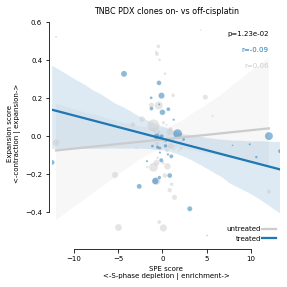

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)

plot_s_predictiveness_cisplatin_combined(df_pdx_combined, ax=ax, title='TNBC PDX clones on- vs off-cisplatin')
sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

plt.show()

### Load and preprocess the SPECTRUM OV-081 data

In [16]:
# load long-form dataframes that have the PERT output for each bin
dataset = 'SPECTRUM-OV-081'
prefix = '../../analysis/spectrum/{}/'.format(dataset)
cn_s_081 = pd.read_csv(prefix+'s_phase_cells_with_scRT_filtered.csv.gz', dtype={'chr':str})
cn_g_081 = pd.read_csv(prefix+'g1_phase_cells_with_scRT_filtered.csv.gz', dtype={'chr':str})


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
cn_g_081.clone_id.unique()

array(['D', 'C', 'G', 'A', 'E'], dtype=object)

In [18]:
cn_s_081.clone_id.unique()

array(['C', 'G', 'D', 'B', 'E', 'A'], dtype=object)

In [19]:
# load the cell cycle clone counts for OV-081
df_081 = pd.read_csv('../../analysis/spectrum/{}/cell_cycle_clone_counts.csv.gz'.format(dataset))

In [20]:
df_081.clone_id.unique()

array(['B', 'C', 'D', 'E', 'G', 'A'], dtype=object)

In [21]:
# rename clone G to clone F since there is no clone F
clone_remap_081 = {'G': 'F'}
cn_s_081['clone_id'] = cn_s_081['clone_id'].replace(clone_remap_081)
cn_g_081['clone_id'] = cn_g_081['clone_id'].replace(clone_remap_081)
df_081['clone_id'] = df_081['clone_id'].replace(clone_remap_081)

# delete clone B from the S-phase population and then move all clones up one index (C->B, D->C, etc.) with the exception of clone A
cn_s_081 = cn_s_081.loc[cn_s_081['clone_id'] != 'B']
cn_g_081 = cn_g_081.loc[cn_g_081['clone_id'] != 'B']
df_081 = df_081.loc[df_081['clone_id'] != 'B']
clone_remap_081 = {'C': 'B', 'D': 'C', 'E': 'D', 'F': 'E', 'G': 'F',}
cn_s_081['clone_id'] = cn_s_081['clone_id'].replace(clone_remap_081)
cn_g_081['clone_id'] = cn_g_081['clone_id'].replace(clone_remap_081)
df_081['clone_id'] = df_081['clone_id'].replace(clone_remap_081)

# add a column for site which maps library 128673A to site 'adnexa' and library 128689A to site 'omentum'
df_081['site'] = df_081['library_id'].replace({'128673A': 'adnexa', '128689A': 'omentum'})

In [22]:
# combine the 081 dataframes
cn_s_081['phase'] = 1
cn_g_081['phase'] = 0
cn_081 = pd.concat([cn_s_081, cn_g_081], ignore_index=True)

In [23]:
def add_SPE_scores(df):
    """Adds a column to the dataframe that contains SPE score for each row in the dataframe. """
    # compute the enrichment or depletion for S-phase cells at a given timepoint
    df['log10_positive_p'] = np.log10(df['positive_p'])
    df['log10_negative_p'] = np.log10(df['negative_p'])
    df['SPE_score'] = df['log10_negative_p'] - df['log10_positive_p']
    return df

# add SPE scores to the dataframe
df_081 = add_SPE_scores(df_081)
df_081

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,clone_id,num_cells_s,num_cells_g,clone_frac_s,clone_frac_g,positive_p,negative_p,library_id,positive_p_adj,negative_p_adj,site,log10_positive_p,log10_negative_p,SPE_score
1,B,278.0,39.0,0.548323,0.481481,8.972549e-20,1.000000e+00,128673A,2.153412e-18,2.400000e+01,adnexa,-1.904708e+01,0.000000e+00,19.047084
2,C,194.0,32.0,0.382643,0.395062,9.118618e-01,8.813820e-02,128673A,2.188468e+01,2.115317e+00,adnexa,-4.007098e-02,-1.054836e+00,-1.014765
3,D,2.0,0.0,0.003945,0.000000,0.000000e+00,1.000000e+00,128673A,0.000000e+00,2.400000e+01,adnexa,-inf,0.000000e+00,inf
4,E,32.0,10.0,0.063116,0.123457,1.000000e+00,1.936229e-13,128673A,2.400000e+01,4.646949e-12,adnexa,-8.408936e-14,-1.271304e+01,-12.713043
5,A,0.0,0.0,0.000000,0.000000,0.000000e+00,1.000000e+00,128673A,0.000000e+00,2.400000e+01,adnexa,-inf,0.000000e+00,inf
6,A,64.0,701.0,0.633663,0.547656,2.719574e-02,9.728043e-01,128689A,6.526977e-01,2.334730e+01,omentum,-1.565499e+00,-1.197454e-02,1.553525
7,B,0.0,2.0,0.000000,0.001563,1.409712e-01,8.590288e-01,128689A,3.383308e+00,2.061669e+01,omentum,-8.508698e-01,-6.599225e-02,0.784878
8,C,5.0,7.0,0.049505,0.005469,8.757351e-07,9.999991e-01,128689A,2.101764e-05,2.399998e+01,omentum,-6.057627e+00,-3.803271e-07,6.057627
9,D,7.0,22.0,0.069307,0.017188,1.215816e-04,9.998784e-01,128689A,2.917957e-03,2.399708e+01,omentum,-3.915132e+00,-5.280541e-05,3.915079
10,E,25.0,548.0,0.247525,0.428125,9.999273e-01,7.272150e-05,128689A,2.399825e+01,1.745316e-03,omentum,-3.158369e-05,-4.138337e+00,-4.138306


In [24]:
def filter_rows(df, num_cells=5):
    """Filters out rows that do not have a value for instantaneous_s or have few cells"""
    # convert SPE values with -inf to -20 and inf to 20
    df['SPE_score'] = df['SPE_score'].replace(-np.inf, -20)
    df['SPE_score'] = df['SPE_score'].replace(np.inf, 20)
    df = df.loc[df['SPE_score'].notna()]
    df = df.loc[df['num_cells_g'] > num_cells]
    return df

# filter out rows that have few cells or no SPE score
filter_rows(df_081)

,clone_id,num_cells_s,num_cells_g,clone_frac_s,clone_frac_g,positive_p,negative_p,library_id,positive_p_adj,negative_p_adj,site,log10_positive_p,log10_negative_p,SPE_score
1,B,278.0,39.0,0.548323,0.481481,8.972549e-20,1.000000e+00,128673A,2.153412e-18,2.400000e+01,adnexa,-1.904708e+01,0.000000e+00,19.047084
2,C,194.0,32.0,0.382643,0.395062,9.118618e-01,8.813820e-02,128673A,2.188468e+01,2.115317e+00,adnexa,-4.007098e-02,-1.054836e+00,-1.014765
4,E,32.0,10.0,0.063116,0.123457,1.000000e+00,1.936229e-13,128673A,2.400000e+01,4.646949e-12,adnexa,-8.408936e-14,-1.271304e+01,-12.713043
6,A,64.0,701.0,0.633663,0.547656,2.719574e-02,9.728043e-01,128689A,6.526977e-01,2.334730e+01,omentum,-1.565499e+00,-1.197454e-02,1.553525
8,C,5.0,7.0,0.049505,0.005469,8.757351e-07,9.999991e-01,128689A,2.101764e-05,2.399998e+01,omentum,-6.057627e+00,-3.803271e-07,6.057627
9,D,7.0,22.0,0.069307,0.017188,1.215816e-04,9.998784e-01,128689A,2.917957e-03,2.399708e+01,omentum,-3.915132e+00,-5.280541e-05,3.915079
10,E,25.0,548.0,0.247525,0.428125,9.999273e-01,7.272150e-05,128689A,2.399825e+01,1.745316e-03,omentum,-3.158369e-05,-4.138337e+00,-4.138306
12,A,64.0,701.0,0.105263,0.515062,1.000000e+00,1.550760e-12,all,1.200000e+01,1.860911e-11,all,-6.734863e-13,-1.180946e+01,-11.809456
14,B,278.0,41.0,0.457237,0.030125,0.000000e+00,1.000000e+00,all,0.000000e+00,1.200000e+01,all,-inf,0.000000e+00,20.000000
15,C,199.0,39.0,0.327303,0.028655,0.000000e+00,1.000000e+00,all,0.000000e+00,1.200000e+01,all,-inf,0.000000e+00,20.000000


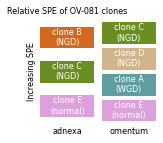

In [25]:
from matplotlib.patches import Rectangle

def plot_relative_SPE_scores(df, ax0, ax1):
    ''' 
    Given a set of rows in df, plot a colored patch of each clone ID sorted by the SPE score.
    The left subplot (ax0) that only plots rows where site=='adnexa' and the right subplot (ax1) that only plots rows where site=='omentum'.
    '''
    # filter the df to only include rows with sufficient cells
    df = filter_rows(df)

    # subset by sites
    df_adnexa = df.loc[df['site']=='adnexa']
    df_omentum = df.loc[df['site']=='omentum']

    # sort the dataframes
    df_adnexa = df_adnexa.sort_values(by='SPE_score', ascending=True)
    df_omentum = df_omentum.sort_values(by='SPE_score', ascending=True)

    # plot adnexa clone IDs sorted by SPE score
    # plot them vertically where each clone ID is a rectangle colored by get_clone_cmap()
    clone_cmap = get_clone_cmap()
    description_map = {
        'A': 'WGD',
        'B': 'NGD',
        'C': 'NGD',
        'D': 'NGD',
        'E': 'normal',
    }
    height = 0.2
    for temp_df, ax in zip([df_adnexa, df_omentum], [ax0, ax1]):
        yspacing = (1 / len(temp_df)) - height
        y = yspacing / 2
        for row in temp_df.iterrows():
            c = row[1]['clone_id']
            color = clone_cmap[c]
            description = description_map[c]
            # clone_legend_elements.append(Patch(facecolor=color, label=c))
            ax.add_patch(Rectangle((0, y), 1, height, color=color))
            # superimpose the clone ID as text over the patch
            ax.text(0.5, y+(height/2), 'clone {}\n({})'.format(c, description), ha='center', va='center', size=MEDIUM_SIZE, color='white')
            y += height + yspacing
        
        # remove all axis borders and ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
    
    ax0.set_xlabel('adnexa', fontsize=MEDIUM_SIZE)
    ax1.set_xlabel('omentum', fontsize=MEDIUM_SIZE)
    ax0.set_ylabel('Increasing SPE', fontsize=MEDIUM_SIZE)
    ax0.set_title('Relative SPE of OV-081 clones', fontsize=MEDIUM_SIZE)

    return ax0, ax1

fig, ax = plt.subplots(1, 2, figsize=(2, 2), tight_layout=True)
plot_relative_SPE_scores(df_081, ax[0], ax[1])
plt.show()

### Plot the PERT CN and replication heatmaps for the SPECTRUM OV-081 data

In [26]:
def get_site_cmap():
    cmap = {
        'SPECTRUM-OV-081_S1_LEFT_ADNEXA': 'powderblue',
        'SPECTRUM-OV-081_S1_INFRACOLIC_OMENTUM': 'darkseagreen',
    }
    return cmap

In [27]:
def plot_pert_cn_heatmap(
    cn, ax_heatmap, ax_clone, ax_phase, ax_site,
    clone_col='clone_id', phase_col='phase', site_col='isabl_sample_id',
    output_cn_col='model_cn_state', secondary_sort_col='model_tau',
    phase_cmap=get_phase_cmap(), clone_cmap=get_clone_cmap(), site_cmap=get_site_cmap(),
    chrom_labels_to_remove=[]
    ):
    ''' 
    Plot PERT output heatmaps for S-phase and G1/2-phase cells. 
    
    Parameters
    ----------
    cn : pandas.DataFrame
        long-form dataframe of S- and G1/2-phase cells with pert model results.
        this dataframe should have the following columns in addition to those specified by additional parameters:
            - chr (categorical)
            - start (int)
            - end (int)
            - cell_id (str)
    ax_heatmap : matplotlib.axes.Axes
        axis for the CN heatmap
    ax_clone : matplotlib.axes.Axes
        axis for the clone ID colorbar annotations
    ax_phase : matplotlib.axes.Axes
        axis for the cell cycle phase colorbar annotations
    ax_site : matplotlib.axes.Axes
        axes for the site colorbar annotations
    clone_col : str
        column name for clone IDs
    phase_col : str
        column name for secondary sorting of cells (e.g. time in S-phase or cell cycle phase)
    output_cn_col : str
        column name for output CN states (from pert)
    phase_cmap : matplotlib.colors.ListedColormap
        colormap for cell cycle phases
    clone_cmap : matplotlib.colors.ListedColormap
        colormap for clone IDs
    site_cmap : matplotlib.colors.ListedColormap
        colormap for site IDs
    chrom_labels_to_remove : list
        chromosomes to remove from x-axis to avoid crowding
    '''

    # create mapping of clone IDs
    cluster_col = 'cluster_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(cn[clone_col].unique()))])
    cn[cluster_col] = cn[clone_col]
    cn = cn.replace({cluster_col: clone_dict})

    # plot the CN states for the S-phase cells
    plot_data = plot_clustered_cell_cn_matrix(
        ax_heatmap, cn, output_cn_col, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_col, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # turn off the y-axis ticks in all subplots
    for ax in [ax_heatmap, ax_site, ax_clone, ax_phase]:
        ax.set_yticks([])
        ax.set_ylabel('')

    # add the colorbars for clone_id and model_tau
    if len(clone_dict) > 1:
        cell_ids = plot_data.columns.get_level_values(0).values
        cluster_ids = plot_data.columns.get_level_values(1).values
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat, _ = cncluster.get_cluster_colors(cluster_ids, color_map=clone_cmap, return_map=True)

        # get array of the site values that match the cell_id order
        condensed_cn = cn[['cell_id', phase_col]].drop_duplicates()
        phase_array = []
        for cell in cell_ids:
            phase = condensed_cn[condensed_cn['cell_id'] == cell][phase_col].values[0]
            phase_array.append(phase)
        
        # use mcolors to change every element of the site cmap dict to rgba
        for key in phase_cmap.keys():
            phase_cmap[key] = mcolors.to_rgba(phase_cmap[key])
        phase_color_mat, _ = cncluster.get_cluster_colors(phase_array, color_map=phase_cmap, return_map=True)

        # get array of the site values that match the cell_id order
        condensed_cn_ = cn[['cell_id', site_col]].drop_duplicates()
        site_array = []
        for cell in cell_ids:
            site = condensed_cn_[condensed_cn_['cell_id'] == cell][site_col].values[0]
            site_array.append(site)
        
        # use mcolors to change every element of the site cmap dict to rgba
        for key in site_cmap.keys():
            site_cmap[key] = mcolors.to_rgba(site_cmap[key])
        site_color_mat, _ = cncluster.get_cluster_colors(site_array, color_map=site_cmap, return_map=True)

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone, color_mat)

        # create color bar that shows secondary sort value for each row in heatmap
        plot_colorbar(ax_phase, phase_color_mat)

        # create color bar that shows site for each row in heatmap
        plot_colorbar(ax_site, site_color_mat)

    # add the x-axis labels
    ax_heatmap.set_xlabel('chromosome')
    ax_clone.set_xticks([0.0])
    ax_clone.set_xticklabels(['clone'], rotation=90)
    ax_phase.set_xticks([0.0])
    ax_phase.set_xticklabels(['phase'], rotation=90)
    ax_site.set_xticks([0.0])
    ax_site.set_xticklabels(['site'], rotation=90)
    ax_clone.set_ylabel('{} cells'.format(cn.cell_id.nunique()))
    ax_heatmap.set_title('PERT somatic CN states')
   

In [28]:
def plot_pert_cn_rep_heatmaps(
    cn_s, cn_g, ax_cn_s, ax_cn_g, ax_rep_s, ax_rep_g, 
    ax_clone_s, ax_clone_g, ax_time_s, ax_time_g, ax_site_s, ax_site_g,
    clone_col='clone_id', second_sort_col='model_tau', site_col='isabl_sample_id',
    output_cn_col='model_cn_state', output_rep_col='model_rep_state',
    rt_cmap=get_rt_cmap(), clone_cmap=get_clone_cmap(), site_cmap=get_site_cmap(),
    chrom_labels_to_remove=[]
    ):
    ''' 
    Plot PERT output heatmaps for S-phase and G1/2-phase cells. 
    
    Parameters
    ----------
    cn_s : pandas.DataFrame
        long-form dataframe of S-phase cells with pert model results.
        this dataframe should have the following columns in addition to those specified by additional parameters:
            - chr (categorical)
            - start (int)
            - end (int)
            - cell_id (str)
    cn_g : pandas.DataFrame
        long-form dataframe of G1/2-phase cells with pert model results.
        this dataframe should have the following columns in addition to those specified by additional parameters:
            - chr (categorical)
            - start (int)
            - end (int)
            - cell_id (str)
    ax_cn_s : matplotlib.axes.Axes
        axes for the S-phase CN heatmap
    ax_cn_g : matplotlib.axes.Axes
        axes for the G1/2-phase CN heatmap
    ax_rep_s : matplotlib.axes.Axes
        axes for the S-phase replication state heatmap
    ax_rep_g : matplotlib.axes.Axes
        axes for the G1/2-phase replication state heatmap
    ax_clone_s : matplotlib.axes.Axes
        axes for the S-phase clone ID colorbar annotations
    ax_clone_g : matplotlib.axes.Axes
        axes for the G1/2-phase clone ID colorbar annotations
    ax_time_s : matplotlib.axes.Axes
        axes for the S-phase time colorbar annotations
    ax_time_g : matplotlib.axes.Axes
        axes for the G1/2-phase time colorbar annotations
    ax_site_s : matplotlib.axes.Axes
        axes for the S-phase site colorbar annotations
    ax_site_g : matplotlib.axes.Axes
        axes for the G1/2-phase site colorbar annotations
    clone_col : str
        column name for clone IDs
    second_sort_col : str
        column name for secondary sorting of cells (e.g. time in S-phase)
    output_cn_col : str
        column name for output CN states (from pert)
    output_rep_col : str
        column name for output replication states (from pert)
    top_title_prefix : str
        prefix for the title of the top row of plots (corresponding to cn_s)
    bottom_title_prefix : str
        prefix for the title of the bottom row of plots (corresponding to cn_g)
    output_cn_title : str
        title for the output CN heatmap in the middle-right column
    rep_title : str
        title for the replication state heatmap in the far-right column
    rt_cmap : matplotlib.colors.ListedColormap
        colormap for replication states
    clone_cmap : matplotlib.colors.ListedColormap
        colormap for clone IDs
    site_cmap : matplotlib.colors.ListedColormap
        colormap for site IDs
    chrom_labels_to_remove : list
        chromosomes to remove from x-axis to avoid crowding
    '''

    # create mapping of clone IDs
    cluster_col = 'cluster_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(cn_g[clone_col].unique()))])
    cn_g[cluster_col] = cn_g[clone_col]
    cn_g = cn_g.replace({cluster_col: clone_dict})
    cn_s[cluster_col] = cn_s[clone_col]
    cn_s = cn_s.replace({cluster_col: clone_dict})

    # plot the CN states for the S-phase cells
    plot_data_cn_s = plot_clustered_cell_cn_matrix(
        ax_cn_s, cn_s, output_cn_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the replication states for the S-phase cells
    plot_data_rep_s = plot_clustered_cell_cn_matrix(
        ax_rep_s, cn_s, output_rep_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, cmap=rt_cmap, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the CN states for the G1/2-phase cells
    plot_data_cn_g = plot_clustered_cell_cn_matrix(
        ax_cn_g, cn_g, output_cn_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the replication states for the G1/2-phase cells
    plot_data_rep_g = plot_clustered_cell_cn_matrix(
        ax_rep_g, cn_g, output_rep_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, cmap=rt_cmap, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # turn off the y-axis ticks in all subplots
    for ax in [ax_cn_s, ax_cn_g, ax_rep_s, ax_rep_g, ax_clone_s, ax_clone_g, ax_time_s, ax_time_g]:
        ax.set_yticks([])
        ax.set_ylabel('')

    # add the colorbars for clone_id and model_tau
    if len(clone_dict) > 1:
        cell_ids_g = plot_data_cn_g.columns.get_level_values(0).values
        cluster_ids_g = plot_data_cn_g.columns.get_level_values(1).values
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat_g, _ = cncluster.get_cluster_colors(cluster_ids_g, color_map=clone_cmap, return_map=True)

        # get array of second_sort_col values that that match the cell_id order
        condensed_cn_g = cn_g[['cell_id', second_sort_col]].drop_duplicates()
        secondary_array_g = []
        for cell in cell_ids_g:
            g = condensed_cn_g[condensed_cn_g['cell_id'] == cell][second_sort_col].values[0]
            secondary_array_g.append(g)

        # make color mat according to secondary array
        secondary_color_mat_g, _ = make_color_mat_float(secondary_array_g, 'Blues')

        # get array of the site values that match the cell_id order
        condensed_cn_g = cn_g[['cell_id', site_col]].drop_duplicates()
        site_array_g = []
        for cell in cell_ids_g:
            site = condensed_cn_g[condensed_cn_g['cell_id'] == cell][site_col].values[0]
            site_array_g.append(site)
        
        # use mcolors to change every element of the site cmap dict to rgba
        for key in site_cmap.keys():
            site_cmap[key] = mcolors.to_rgba(site_cmap[key])
        site_color_mat_g, _ = cncluster.get_cluster_colors(site_array_g, color_map=site_cmap, return_map=True)

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone_g, color_mat_g)

        # create color bar that shows secondary sort value for each row in heatmap
        plot_colorbar(ax_time_g, secondary_color_mat_g)

        # create color bar that shows site for each row in heatmap
        plot_colorbar(ax_site_g, site_color_mat_g)

        # repeat for the S-phase cells
        cell_ids_s = plot_data_cn_s.columns.get_level_values(0).values
        cluster_ids_s = plot_data_cn_s.columns.get_level_values(1).values
        color_mat_s, _ = cncluster.get_cluster_colors(cluster_ids_s, color_map=clone_cmap, return_map=True)

        # get array of second_sort_col values that that match the cell_id order
        condensed_cn_s = cn_s[['cell_id', second_sort_col]].drop_duplicates()
        secondary_array_s = []
        for cell in cell_ids_s:
            s = condensed_cn_s[condensed_cn_s['cell_id'] == cell][second_sort_col].values[0]
            secondary_array_s.append(s)
        
        # make color mat according to secondary array
        secondary_color_mat_s, _ = make_color_mat_float(secondary_array_s, 'Blues')

        # get array of the site values that match the cell_id order
        condensed_cn_s = cn_s[['cell_id', site_col]].drop_duplicates()
        site_array_s = []
        for cell in cell_ids_s:
            site = condensed_cn_s[condensed_cn_s['cell_id'] == cell][site_col].values[0]
            site_array_s.append(site)

        site_color_mat_s, _ = cncluster.get_cluster_colors(site_array_s, color_map=site_cmap, return_map=True)

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone_s, color_mat_s)

        # create color bar that shows secondary sort value for each row in heatmap
        plot_colorbar(ax_time_s, secondary_color_mat_s)

        # create color bar that shows site for each row in heatmap
        plot_colorbar(ax_site_s, site_color_mat_s)


### Plot the S-phase enrichment of SPECTRUM OV-081 clones across all timepoints

In [29]:
def plot_clone_spf_all_libraries(df, ax, dataset, pt_size=5):
    ''' Plot the distribution of cell cycle phases for each clone across all libraries in a sample '''
    pthresh = 1e-2

    # create custom legend for clones & libraries
    clone_cmap = get_clone_cmap()
    library_cmap = {}
    clone_legend_elements = [
        Line2D([0], [0], marker='^', color='w', label='enriched', markerfacecolor='k', markersize=pt_size),
        Line2D([0], [0], marker='o', color='w', label='non-sig.', markerfacecolor='k', markersize=pt_size),
        Line2D([0], [0], marker='v', color='w', label='depleted', markerfacecolor='k', markersize=pt_size)
    ]
    
    # for i, c in enumerate(sorted(df.clone_id.unique())):
    #     color = clone_cmap[c]
    #     clone_legend_elements.append(Patch(facecolor=color, label=c))
    
    # the left panel shows the distribution of cell cycle phases for each clone where library_id=='all'
    df2 = df.query('library_id=="all"').reset_index(drop=True)
    for i, row in df2.iterrows():
        clone_id = row['clone_id']
        if row['positive_p_adj'] < pthresh:
            ax.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], c=clone_cmap[clone_id], marker='^', s=pt_size)
        elif row['negative_p_adj'] < pthresh:
            ax.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], c=clone_cmap[clone_id], marker='v', s=pt_size)
        else:
            ax.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], c=clone_cmap[clone_id], s=pt_size)

    # draw y=x line where we expect "neutral" clones to lie
    # limits for the left panel
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', alpha=0.25, zorder=0)

    ax.legend(handles=clone_legend_elements, title='S-phase', frameon=False, loc='upper right')
    ax.set_xlabel('G1/2-phase clone fraction')
    ax.set_ylabel('S-phase clone fraction')
    ax.set_title('{}: S-phase enrichment'.format(dataset))
    

### Create an entire multipanel figure for the main figure of the paper

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


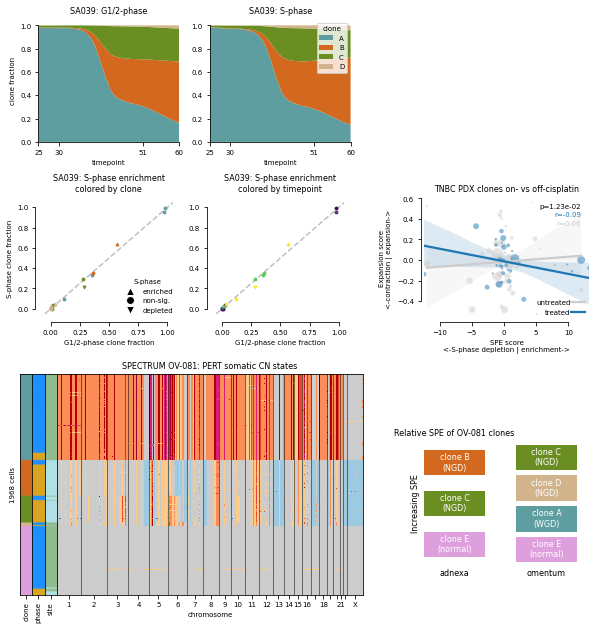

In [30]:
# create a large 8.5 x 11 figure and manually add all the subplots with custom positioning
# since I'm adding labels the figure will be slightly larger than the specified size,
# thus I need to divide the width and height by a multiplicative factor to get the correct size
mult_factor = 1.0
fig = plt.figure(figsize=(8.5/mult_factor, 8.5/mult_factor))

# add an axis in the top left of the figure with size 0.23 x 0.2
ax0 = fig.add_axes([0.07, 0.79, 0.23, 0.2])
ax0.set_title('ax0')

# add an axis in the top middle of the figure with size 0.23 x 0.2
ax1 = fig.add_axes([0.35, 0.79, 0.23, 0.2], sharey=ax0)
ax1.set_title('ax1')

# add two more axes underneath the first two axes
ax2 = fig.add_axes([0.07, 0.5, 0.23, 0.2])
ax2.set_title('ax2\nax2')
ax3 = fig.add_axes([0.35, 0.5, 0.23, 0.2], sharey=ax2)
ax3.set_title('ax3')

# add an axes at the same height as ax2 but to the right of ax3 with more width
ax4 = fig.add_axes([0.7, 0.5, 0.27, 0.2])
# ax4.set_title('ax4')

# add a heatmap with 3 barplots to the left in the bottom left corner of the figure
ax5 = fig.add_axes([0.1, 0.05, 0.5, 0.36])
# ax5.set_title('ax5')
ax6 = fig.add_axes([0.04, 0.05, 0.02, 0.36])
# ax6.set_title('ax6')
ax7 = fig.add_axes([0.06, 0.05, 0.02, 0.36])
# ax7.set_title('ax7')
ax8 = fig.add_axes([0.08, 0.05, 0.02, 0.36])
# ax8.set_title('ax8')

# add an axes of 0.25 x 0.25 size in the bottom right corner of the figure
ax9 = fig.add_axes([0.7, 0.1, 0.1, 0.2])
ax10 = fig.add_axes([0.85, 0.1, 0.1, 0.2])


# plot clone fractions for each phase & timepoint in the form of a stackplot
plot_clone_muller(df_SA039, 'SA039', ax0, ax1, std=50)
sns.despine(ax=ax0, offset=0, trim=despine_trim)
sns.despine(ax=ax1, offset=0, trim=despine_trim)

# plot the S-phase enrichment plots in ax2 and ax3
plot_s_phase_enrichment(df_SA039, 'SA039', ax2, ax3, pt_size=8)
sns.despine(ax=ax2, offset=despine_offset, trim=despine_trim)
sns.despine(ax=ax3, offset=despine_offset, trim=despine_trim)

# plot S-phase enrichment vs observed clone shift in G1/2 population for all PDX samples
plot_s_predictiveness_cisplatin_combined(df_pdx_combined, ax4, title='TNBC PDX clones on- vs off-cisplatin')
sns.despine(ax=ax4, offset=despine_offset, trim=despine_trim)

plot_pert_cn_heatmap(
    cn_081, ax5, ax6, ax7, ax8,
    secondary_sort_col='phase',
    chrom_labels_to_remove=['17', '19', '20', '22']
)
ax5.set_title('SPECTRUM OV-081: PERT somatic CN states')

# plot S-phase enrichment of OV-081 clones across all libraries
# plot_clone_spf_all_libraries(df_081, ax9, dataset='SPECTRUM OV-081', pt_size=8)
# sns.despine(ax=ax9, offset=despine_offset, trim=despine_trim)

# plot the relative SPE scores for OV-081 clones
plot_relative_SPE_scores(df_081, ax9, ax10)

fig.savefig('../../manuscript/main_figs/fig6.pdf', dpi=300, bbox_inches='tight')

plt.show()